In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics
import branca

import shared_utils

from siuba import *
import pandas as pd
import geopandas as gpd
import shapely

import datetime as dt
import time
from zoneinfo import ZoneInfo

import rt_analysis as rt
import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

# Scratch notebook for handling long stop to stop segments

* goal is to provide additional map detail for rural/express routes

In [50]:
## KART speedmap as displayed on site
itp_id = 148
analysis_date = dt.date(2022, 6, 1)

In [4]:
pbar = tqdm()

0it [00:00, ?it/s]

In [5]:
kart_analysis = rt.OperatorDayAnalysis(itp_id, analysis_date, pbar)

found parquet
found parquet
found parquet
found parquet
found parquet
could not interpolate segments for shape 73
could not interpolate segments for shape 1
could not interpolate segments for shape 21
could not interpolate segments for shape 23
could not interpolate segments for shape 36


In [6]:
kart_analysis.rt_trips >> filter(_.route_short_name=='12')


,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,route_short_name,route_long_name,route_desc,route_type,median_time,direction,mean_speed_mph,calitp_agency_name
266,148,0,2022-06-01,2644978890892601525,949,12,0,11,2021-07-02,2099-01-01,12,Avenal,None,3,12:27:19,Westbound,32.276222,Kings Area Rural Transit
267,148,0,2022-06-01,3494167986599370378,947,12,0,3,2021-07-02,2099-01-01,12,Avenal,None,3,07:26:32,Southbound,38.555013,Kings Area Rural Transit
268,148,0,2022-06-01,-4140891564404050759,950,12,0,27,2021-07-02,2099-01-01,12,Avenal,None,3,17:44:36.500000,Westbound,40.296843,Kings Area Rural Transit


In [7]:
line = (kart_analysis.routelines >> filter(_.shape_id == '3')).geometry.iloc[0]

In [9]:
import numpy as np

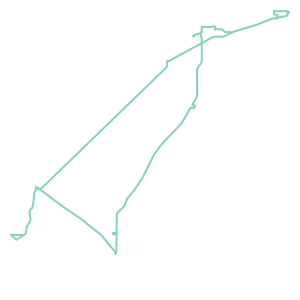

In [64]:
line

In [65]:
line.coords[0]

(31140.27960630121, -187873.97182878666)

In [10]:
shape_start = np.array(line.coords[0])

In [11]:
shape_end = np.array(line.coords[-1])

In [12]:
# fast way to get euclidian distance using numpy!
np.linalg.norm(shape_start - shape_end)

78.04150837797476

In [37]:
positions = kart_analysis.position_interpolators['947']['rt'].position_gdf

In [43]:
positions = (positions >> mutate(veh_time = _.vehicle_timestamp.apply(lambda x: x.strftime('%H:%M:%S')))
             >> select(_.shape_meters, _.veh_time, _.geometry)
            )

In [46]:
cleaned_positions = (kart_analysis.position_interpolators['947']['rt'].cleaned_positions >> mutate(veh_time = _.vehicle_timestamp.apply(lambda x: x.strftime('%H:%M:%S')))
                    >> select(_.shape_meters, _.veh_time, _.geometry)
                    )

In [68]:
# pd.concat([cleaned_positions,
#            (kart_analysis.routelines >> filter(_.shape_id == '3') >> select(_.geometry))]
#          ).explore(tiles = "CartoDB positron")

In [69]:
# kart_analysis.position_interpolators['947']['rt'].detailed_speed_map()

# Mapping Short Segments

In [15]:
kart_analysis.export_views_gcs()

In [16]:
import rt_filter_map_plot

In [51]:
importlib.reload(rt_filter_map_plot)

<module 'rt_filter_map_plot' from '/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py'>

In [52]:
analysis_date

datetime.date(2022, 6, 1)

In [53]:
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

found parquet


In [54]:
rt_day.rt_trips >> filter(_.route_short_name == '12')

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,route_short_name,route_long_name,route_desc,route_type,median_time,direction,mean_speed_mph,calitp_agency_name
266,148,0,2022-06-01,2644978890892601525,949,12,0,11,2021-07-02,2099-01-01,12,Avenal,None,3,12:27:19,Westbound,32.276222,Kings Area Rural Transit
267,148,0,2022-06-01,3494167986599370378,947,12,0,3,2021-07-02,2099-01-01,12,Avenal,None,3,07:26:32,Southbound,38.555013,Kings Area Rural Transit
268,148,0,2022-06-01,-4140891564404050759,950,12,0,27,2021-07-02,2099-01-01,12,Avenal,None,3,17:44:36.500000,Westbound,40.296843,Kings Area Rural Transit


In [55]:
rt_day.set_filter(route_names=['12'], trip_ids=['947'])

In [56]:
filtered = rt_day._filter(rt_day.stop_delay_view) >> arrange(_.stop_sequence)

In [63]:
rt_day.debug_dict['3_st_spd2'] >> arrange(_.speed_mph)

,stop_id,stop_name,geometry,shape_id,shape_meters,trip_key,trip_id,stop_sequence,route_id,route_short_name,...,seconds_from_last,last_loc,meters_from_last,speed_from_last,delay_chg_sec,speed_mph,n_trips,avg_mph,_20p_mph,trips_per_hour
105,100,KART Transfer Center,"LINESTRING (30627.177 -187608.797, 30554.554 -...",3,49.554622,3.494168e+18,947,31.000000,12,12,...,77656.0,152159.127316,-152109.572694,-1.958761,0.0,-4.381749,1,-4.381749,-4.381749,0.073826
76,None,None,"LINESTRING (16838.630 -191179.796, 16782.928 -...",3,127000.000000,NaN,947,20.142857,12,12,...,85928.0,133656.243832,-6656.243832,-0.077463,NaN,-0.173285,1,-0.173285,-0.173285,0.073826
80,None,None,"LINESTRING (17248.891 -190134.591, 17241.824 -...",3,130000.000000,NaN,947,20.571429,12,12,...,85917.0,135000.000000,-5000.000000,-0.058196,NaN,-0.130184,1,-0.130184,-0.130184,0.073826
34,141,Milham & Becky Pease,"LINESTRING (3663.179 -222998.081, 3663.348 -22...",3,92139.482462,3.494168e+18,947,9.000000,12,12,...,350.0,92000.000000,139.482462,0.398521,NaN,0.891492,1,0.891492,0.891492,0.073826
35,142,Milham @ Housing Authority,"LINESTRING (3567.105 -222975.414, 3506.694 -22...",3,92354.935120,3.494168e+18,947,10.000000,12,12,...,185.0,92139.482462,215.452657,1.164609,121.0,2.605230,1,2.605230,2.605230,0.073826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,None,None,"LINESTRING (25878.888 -189826.462, 25942.048 -...",3,146000.000000,NaN,947,22.666667,12,12,...,34.0,145000.000000,1000.000000,29.411765,NaN,65.794118,1,65.794118,65.794118,0.073826
95,None,None,"LINESTRING (26813.605 -189472.203, 27059.903 -...",3,147000.000000,NaN,947,22.750000,12,12,...,34.0,146000.000000,1000.000000,29.411765,NaN,65.794118,1,65.794118,65.794118,0.073826
17,None,None,"LINESTRING (-6680.118 -217462.711, -6509.610 -...",3,76000.000000,NaN,947,8.413793,12,12,...,33.0,75000.000000,1000.000000,30.303030,NaN,67.787879,1,67.787879,67.787879,0.073826
91,None,None,"LINESTRING (23008.423 -190698.415, 23062.056 -...",3,143000.000000,NaN,947,22.416667,12,12,...,33.0,142000.000000,1000.000000,30.303030,NaN,67.787879,1,67.787879,67.787879,0.073826


In [57]:
m = rt_day.segment_speed_map()

/opt/conda/lib/python3.10/site-packages/shapely/ops.py:639: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py:343: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py:343: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [70]:
# m

## Another Operator

In [26]:
itp_id = 300

In [27]:
pbar = tqdm()

0it [00:00, ?it/s]

In [28]:
importlib.reload(rt)

<module 'rt_analysis' from '/home/jovyan/data-analyses/rt_delay/rt_analysis.py'>

In [29]:
rt_analysis = rt.OperatorDayAnalysis(itp_id, analysis_date, pbar)

found parquet
found parquet
found parquet
found parquet
found parquet
could not interpolate segments for shape 25929
could not interpolate segments for shape 25950


In [30]:
rt_analysis.export_views_gcs()

In [31]:
rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date)

found parquet


In [32]:
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [33]:
m = rt_day.segment_speed_map(how='low_speeds')

/opt/conda/lib/python3.10/site-packages/shapely/ops.py:639: ShapelyDeprecationWarning: GeometryTypeError will derive from ShapelyError and not TypeError or ValueError in Shapely 2.0.
/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py:343: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_filter_map_plot.py:343: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [71]:
# m